## Imports & Classes


In [1]:
# Imports
from aspire.source import Simulation, ArrayImageSource
from aspire.basis import FSPCABasis, SteerableBasis2D
from aspire.classification import RIRClass2D, TopClassSelector
from aspire.noise import WhiteNoiseAdder, AnisotropicNoiseEstimator, CustomNoiseAdder
from aspire.utils import gaussian_2d
from aspire.operators import FunctionFilter, RadialCTFFilter
from sklearn.neighbors import NearestNeighbors
from aspire.volume import Volume
from scipy.spatial.transform import Rotation as sp_rot
from tqdm.notebook import tqdm
from aspire.image import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from collections  import OrderedDict
from collections import namedtuple
from itertools import product
from torch.utils.tensorboard import SummaryWriter # TensorBoard support
from IPython.display import clear_output
from PIL import Image as PILImage

import logging
import numpy as np
import pandas as pd
import torch
import time
import json
import matplotlib.pyplot as plt

torch.set_grad_enabled(True)  
logger = logging.getLogger(__name__)
logger.disabled = True

clear_output()

In [2]:
class BasisComputer():
    def __init__(self, src, num_components, num_neighbors, batch_size = 512, withRefl = True):
        # Attributes
        self.src = src
        self.num_components = num_components
        self.num_neighbors = num_neighbors

        # Basis Computation
        self.basis = FSPCABasis(src = src, components=num_components, batch_size = batch_size)
        self.fixed_ang_indices = self.basis.fixed_angular_indices
        self.k_max = self.basis.k_max

        # Inner & Coef Computations
        self.rot_vecs = BasisComputer.rotation_vectors(src=src, withRefl = withRefl)
        self.coefs = BasisComputer.stacked_coefficients(basis = self.basis, withRefl = withRefl)
        self.ngh_indices, self.ngh_inners = self.nearest_inners(num_neighbors = num_neighbors, rot_vecs = self.rot_vecs)
    
    # Normalized & Reflection stacked rotation vector
    @staticmethod
    def rotation_vectors(src, withRefl = True):
        sp_rotations = sp_rot.from_matrix(src.rotations)
        rot_vecs = sp_rotations.as_rotvec()
        rot_vecs /= np.linalg.norm(rot_vecs, axis=-1)[:,np.newaxis]
        rot_vecs = torch.from_numpy(rot_vecs)
        if withRefl == True:
            rot_vecs = torch.stack((rot_vecs,rot_vecs), dim=1).view(2*rot_vecs.shape[0],rot_vecs.shape[1])
        return rot_vecs

    # PCA Complex Coefficients with Reflected Coefs Stacked
    @staticmethod
    def stacked_coefficients(basis, withRefl):
        coefs = basis.spca_coef
        coefs = basis.to_complex(coefs)
        coefs = torch.from_numpy(coefs).type(torch.cfloat)
        if withRefl == False:
            return coefs
        else:
            # Computing & Stacking Reflection Coefficients 
            coefs_with_refl = torch.zeros(2*coefs.shape[0], coefs.shape[1], dtype = torch.cfloat)
            fixed_ang_indices = basis.fixed_angular_indices
            for i in range(coefs.shape[0]):
                temp_coef = coefs[i,]
                coefs_with_refl[2*i,] = temp_coef
                temp_for_refl = temp_coef.clone()
                to_change = coefs_with_refl[2*i+1, ]
                for k, k_indices in fixed_ang_indices.items():
                    to_change[k_indices] = torch.pow(torch.tensor(-1), k)*torch.conj(temp_for_refl[k_indices])
            return coefs_with_refl

    def nearest_inners(self, num_neighbors, rot_vecs):
        # Neighbors (keep num even because of redundancy in rot_vecs)
        nbrs = NearestNeighbors(n_neighbors=num_neighbors).fit(rot_vecs)
        # Get neighbor indices
        distances, ngh_indices  = nbrs.kneighbors(rot_vecs)
        # Get neighbor inners
        ngh_inners = np.zeros(ngh_indices.shape)
        for index in np.ndindex(ngh_inners.shape):
            ngh_inners[index] = np.dot(rot_vecs[index[0]],rot_vecs[ngh_indices[index[0],index[1]]])
        ngh_inners = torch.Tensor(ngh_inners)
        return ngh_indices, ngh_inners        

class Build_Data(Dataset):    
    # Constructor
    def __init__(self, coefs):
        self.coefs = coefs
        self.len = self.coefs.shape[0]        
    # Getting the data
    def __getitem__(self, index):    
        return index   
    # Getting length of the data
    def __len__(self):
        return self.len

class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.loss_data = {}
    self.params_data = {}
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images to TensorBoard  
  def begin_run(self, run, loader, basis_computer, src, comment = ""):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1
    self.loss_data[self.run_count] = []
    self.params_data[self.run_count] = []

    self.loader = loader
    self.basis_computer = basis_computer
    self.src = src
    
    self.tb = SummaryWriter(comment = comment)
    self.savepath = self.tb.log_dir
    torch.save(obj = run._asdict(), f = self.savepath + '/run_parameters.pt')


    #images, labels = next(iter(self.loader))
    #grid = torchvision.utils.make_grid(images)
    #self.tb.add_image('images', grid)
    #self.tb.add_graph(self.network, images)

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0
    torch.save(obj = self.run_data, f = self.savepath + '/run_data.pt')
    torch.save(obj = self.loss_data, f = self.savepath + '/loss_data.pt')
    torch.save(obj = self.params_data, f = self.savepath + '/params_data.pt')
    torch.save(obj = self.src, f = self.savepath + '/src.pt')
    torch.save(obj = self.basis_computer, f = self.savepath + '/basis_computer.pt')
    torch.save(obj = self.basis_computer.basis, f = self.savepath + '/pca_basis.pt')

    parameter_images = self.basis_computer.basis.evaluate_to_image_basis(self.basis_computer.basis.to_real(self.epoch_parameters.detach().numpy())).asnumpy().astype(np.float64)
    torch.save(obj = parameter_images, f = self.savepath + '/Z_images_end.pt')

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss
    Z = self.epoch_parameters
    # accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Log Loss', np.log(loss), self.epoch_count)
    # self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard
    # for name, param in self.network.named_parameters():
    #  self.tb.add_histogram(name, param, self.epoch_count)
    #  self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["Z"] = Z
    #results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    self.loss_data[self.run_count].append(loss)
    self.params_data[self.run_count].append(Z)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')
    df = df.drop(columns = ['Z', 'Z_init'])
    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss = loss.item()
  def track_parameters(self, Z):
    self.epoch_parameters = Z

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)
  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  # save end results of all runs into csv, json for further analysis
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)


class Max_Filter_Neighbor_Training():

    def __init__(self, basis_computer, Z = None, num_templates_init = None, re_init_templates = False, padding = 400):

        # Attributes
        self.coefs = basis_computer.coefs
        self.ngh_inners = basis_computer.ngh_inners
        self.ngh_indices = basis_computer.ngh_indices
        self.fixed_ang_indices = basis_computer.fixed_ang_indices
        self.k_max = basis_computer.k_max
        self.padding = padding

        # Initialize templates if needed
        if (Z == None) or (re_init_templates == True):
            coefs = self.coefs
            indices_perm = torch.randperm(len(coefs))[:num_templates_init]
            coefs_copy = coefs.data.clone()
            self.Z = coefs_copy[indices_perm].requires_grad_(True)
            self.num_temp = num_templates_init
        else:
            self.Z = Z
            self.num_temp = Z.shape[0]
    
    def __call__(self, batch_indices):
        return self.max_filter_ngh_loss(batch_indices = batch_indices)

    def parameters(self):
        return [self.Z]
    
    # Max-filter one coefficient vector with the entire template bank
    def max_filter_bank_torch(self, complex_coef):
        Z = self.Z
        padding = self.padding
        fixed_ang_indices = self.fixed_ang_indices
        k_max = self.k_max

        num_temp = Z.shape[0]
        bank = torch.zeros(num_temp)
        for i in range(num_temp):
            # Get template
            template = Z[i]
            # Compute Max-Filter
            inner_with_zeros = torch.zeros(int(k_max) + padding + 1, dtype=torch.cfloat)
            for k, k_indices in fixed_ang_indices.items():
                zk = complex_coef[k_indices]
                wk = template[k_indices]
                inner_with_zeros[k] = torch.linalg.vecdot(zk,wk)
            transformed_inner = torch.fft.fft(inner_with_zeros)
            real_part = torch.max(torch.real(transformed_inner))
            # Update Bank
            bank[i] = real_part
        return bank

    # Obtain batch loss with neighbors 
    def max_filter_ngh_loss(self, batch_indices = None):
        coefs = self.coefs
        ngh_inners = self.ngh_inners
        ngh_indices = self.ngh_indices
        num_temp = self.num_temp

        # If no batching is considered, do entire descent
        # Relevant indices are row indices of the relevant coefs and all their neighbors 
        if batch_indices == None:
            batch_indices = range(coefs.shape[0])
            relevant_row_indices = batch_indices
        else:
            relevant_row_indices  = np.unique(ngh_indices[batch_indices,].flatten())

        # Inverse relevant is a dictionary mapping ordered relevant indices to a sequential range
        inverse_relevant = {}
        num_relevant = len(relevant_row_indices)
        batch_size = len(batch_indices)
        num_neighbors = ngh_indices.shape[1]

        # Obtain max filter banks for all neighbors and update inverse relevant
        filter_banks = torch.zeros(num_temp, num_relevant)
        for i in range(num_relevant):
            rel_row_index = relevant_row_indices[i]
            inverse_relevant[rel_row_index] = i
            filter_banks[:,i] = self.max_filter_bank_torch(complex_coef = coefs[rel_row_index])

        # Obtain inner products between banks of every coefficient and its neighbors
        bank_inners = torch.zeros(batch_size,num_neighbors)
        for i in range(batch_size):
            coef_row_index = batch_indices[i]
            coef_pure_index = inverse_relevant[int(coef_row_index)]
            coef_neighbors = ngh_indices[coef_row_index,:]
            for j in range(num_neighbors):
                neighbor_row_index = coef_neighbors[j]
                neighbor_pure_index = inverse_relevant[neighbor_row_index]
                bank_inners[i,j] = torch.linalg.vecdot(filter_banks[:,coef_pure_index], filter_banks[:,neighbor_pure_index])

        # Return 
        return torch.pow(torch.linalg.matrix_norm(bank_inners - ngh_inners[batch_indices,:]),2)

def gaussian_2D_mix(L = 32, N = 512):
    round_disc = gaussian_2d(L, sigma=L / 4)
    oval_disc = gaussian_2d(L, sigma=(L / 20, L / 5))
    # Create a second oval.
    oval_disc2 = gaussian_2d(L, mu=(L / 5, L / 6), sigma=(L / 15, L / 20))

    # Strategically add it to `oval_disc`.
    yoval_discL = oval_disc.copy()
    yoval_discL += oval_disc2
    yoval_discR = np.flipud(yoval_discL)

    thetas = np.linspace(start=0, stop=360, num=N, endpoint=False)

    classRound = np.zeros((N, L, L))
    classOval = np.zeros((N, L, L))
    classYOvalL = np.zeros((N, L, L))
    classYOvalR = np.zeros((N, L, L))

    for i, theta in enumerate(thetas):
        classRound[i] = np.asarray(PILImage.fromarray(round_disc).rotate(theta))
        classOval[i] = np.asarray(PILImage.fromarray(oval_disc).rotate(theta))
        classYOvalL[i] = np.asarray(PILImage.fromarray(yoval_discL).rotate(theta))
        classYOvalR[i] = np.asarray(PILImage.fromarray(yoval_discR).rotate(theta))


    # We'll make an example data set by concatentating then shuffling these.
    example_array = np.concatenate((classRound, classOval, classYOvalL, classYOvalR))

    trueNgh1 = list(np.repeat(np.reshape(range(2*N),(2,-1)), N, axis = 0))
    trueNgh2 = list(np.repeat(np.reshape(range(2*N, 4*N), (1, -1)), 2*N, axis = 0))
    trueNgh = trueNgh1 + trueNgh2

    np.random.seed(1234567)
    p = np.random.permutation(4*N).astype(int)
    inverse_perm = np.argsort(p)
    example_array = example_array[p]
    trueNgh = list(np.array(trueNgh)[p])
    for nghArray in trueNgh:
        for index, entry in enumerate(nghArray):
            nghArray[index] = inverse_perm[entry]


    # So now that we have cooked up an example dataset, lets create an ASPIRE source
    srcTest = ArrayImageSource(example_array)

    # Using the sample variance, we'll compute a target noise variance
    # Noise
    var = np.var(srcTest.images[:].asnumpy())
    noise_var = var * 2**4

    # Then create noise with the ``WhiteNoiseAdder`` class.
    noise = WhiteNoiseAdder(var=noise_var, seed=123)

    # Add noise to the images by performing ``forward``
    noisy_im = noise.forward(srcTest.images[:])

    # Recast as an ASPIRE source
    noisy_srcTest = ArrayImageSource(noisy_im)

    clear_output()

    return srcTest, noisy_srcTest, trueNgh


def percentage_correct_true_ngh(estNgh, trueNgh):
    totalEst = estNgh.size
    check = 0
    mistakes = {}
    for imageIndex, estImageNghs in enumerate(estNgh):
        trueImageNghs = trueNgh[imageIndex]
        for nghIndex in estImageNghs:
            if nghIndex in trueImageNghs:
                check = check + 1
            else:
                mistakes.setdefault(imageIndex, []).append(nghIndex)
    return check/totalEst, mistakes

def percentage_correct_rot_vecs(estNgh, rot_vecs, inner_cutoff = 0.95):
    totalEst = estNgh.size
    check = 0
    mistakes = {}
    for imageIndex, estImageNghs in enumerate(estNgh):
        for nghIndex in estImageNghs:
            if np.dot(rot_vecs[imageIndex], rot_vecs[nghIndex]) >= inner_cutoff:
                check = check + 1
            else:
                mistakes.setdefault(imageIndex, []).append(nghIndex)
    return check/totalEst, mistakes

def neighbor_assessment(src, trueNgh,
    trained_templates,
    num_select_templates = 100,
    fspca_components = 400,
    bispectrum_components = 300,
    n_nbor = 10
):
    rir_max_select_source = RIRClass2D(
        src = src,
        fspca_components= fspca_components,
        bispectrum_components=bispectrum_components,
        n_nbor=n_nbor,
        n_classes=10,
        large_pca_implementation="legacy",
        nn_implementation="sklearn",
        max_filter=True,
        max_filter_method="fft",
        max_filter_fft_padding = 400,
        max_filter_template_selection = "random_source",
        bispectrum_implementation="legacy",
        templates = num_select_templates,
        num_procs=1
    )
    classes_max_select_source, reflections_max_select_source, dists_max_select_source = rir_max_select_source.classify()
    percentage_max_select, mistakes_max_select = percentage_correct_true_ngh(classes_max_select_source, trueNgh)

    rir_bi = RIRClass2D(
        src = src,
        fspca_components=fspca_components,
        bispectrum_components=bispectrum_components,
        n_nbor=n_nbor,
        n_classes=10,
        selector=TopClassSelector(),
        large_pca_implementation="legacy",
        nn_implementation="sklearn",
        max_filter= False,
        bispectrum_implementation="legacy",
        num_procs=1
    )

    classes_bi, reflections_bi, dists_bi = rir_bi.classify()
    percentage_bi, mistakes_bi = percentage_correct_true_ngh(classes_bi, trueNgh)

    rir_max = RIRClass2D(
        src = src,
        fspca_components= fspca_components,
        bispectrum_components=bispectrum_components,
        n_nbor=n_nbor,
        n_classes=10,
        large_pca_implementation="legacy",
        nn_implementation="sklearn",
        max_filter=True,
        max_filter_method="fft",
        max_filter_fft_padding = 400,
        max_filter_template_selection = "explicit",
        bispectrum_implementation="legacy",
        templates = trained_templates,
        num_procs=1
    )

    classes_max, reflections_max, dists_max = rir_max.classify()
    percentage_max, mistakes_max = percentage_correct_true_ngh(classes_max, trueNgh)

    return {
        'Trained_Templates': [percentage_max, mistakes_max],
        'Select_Source' : [percentage_max_select, mistakes_max_select],
        'Bispectrum': [percentage_bi, mistakes_bi]
    }

def train_model(params):
    
    m = RunManager()

    for run in RunBuilder.get_runs(params):
      # Create Simulation
      src = run.src
      # Call Basis Computer
      basis_computer = BasisComputer(src = src, num_components= run.num_components, num_neighbors= run.num_neighbors)
      # Obtain Batched Data
      dataset_row_indices = Build_Data(coefs=basis_computer.coefs)
      train_row_indices = DataLoader(dataset_row_indices, batch_size = len(dataset_row_indices) if run.batch_size is None else run.batch_size)
      # Initialize Model
      model = Max_Filter_Neighbor_Training(basis_computer = basis_computer, Z = run.Z_init, num_templates_init = run.num_templates_init)
      Z = model.Z

      # Initialize Optimizer
      optim = torch.optim.SGD(model.parameters(), lr = run.lr, momentum = run.momentum)

      m.begin_run(run = run, loader = train_row_indices, basis_computer = basis_computer, src = src)

      # Training Initialization
      Z_hist = [Z.data.clone()]
      W_hist = []
      Zgrad_hist = []
      optim.zero_grad()
      # Perform Training
      for s in tqdm(range(run.steps)):
        m.begin_epoch()
        print("Begin Epoch" + str(s))
        # Compute Epoch Loss
        Z_hist.append(Z.data.clone())
        W_epoch = model(batch_indices = None)
        print("Pre-Epoch Loss Computed")
        W_hist.append(W_epoch.data.clone().numpy())
        if len(train_row_indices) == 1:
          W_epoch.backward()
          m.track_loss(W_epoch)
          m.track_parameters(Z)
        else: # Batch Optimize
          for batch_indices in tqdm(train_row_indices):
            W_hat = model(batch_indices=batch_indices)
            W_hat.backward()
            m.track_loss(W_hat)
            m.track_parameters(Z)

        optim.step()
        m.end_epoch()
        optim.zero_grad()
      m.end_run() 

def simulation_src(img_size = 64, num_images = 2000):
    src = Simulation(L= img_size, n= num_images)
    return src

def projection_src(map_path, sim = "small", noise_variance = 5e-5, show_images = True):
    if sim == "small":
        interactive = True  # Draw blocking interactive plots?
        do_cov2d = False  # Use CWF coefficients
        img_size = 32  # Downsample the volume to a desired resolution
        num_imgs = 10000  # How many images in our source.
        n_classes = 1000  # How many class averages to compute.
        n_nbor = 10  # How many neighbors to stack
        noise_variance = noise_variance  # Set a target noise variance

    if sim == "medium":
        interactive = True  # Draw blocking interactive plots?
        do_cov2d = False  # Use CWF coefficients
        img_size = 64  # Downsample the volume to a desired resolution
        num_imgs = 20000  # How many images in our source.
        n_classes = 2000  # How many class averages to compute.
        n_nbor = 10  # How many neighbors to stack
        noise_variance = noise_variance  # Set a target noise variance

    if sim == "large":
        interactive = True  # Draw blocking interactive plots?
        do_cov2d = False  # Use CWF coefficients
        img_size = 129  # Downsample the volume to a desired resolution
        num_imgs = 30000  # How many images in our source.
        n_classes = 2000  # How many class averages to compute.
        n_nbor = 20  # How many neighbors to stack
        noise_variance = noise_variance  # Set a target noise variance

    og_v = Volume.load(map_path, dtype=np.float64)
    v = og_v.downsample(img_size)
    L = v.resolution
    def noise_function(x, y):
        alpha = 1
        beta = 1
        # White
        f1 = noise_variance
        # Violet-ish
        f2 = noise_variance * (x * x + y * y) / L * L
        return (alpha * f1 + beta * f2) / 2.0
    custom_noise = CustomNoiseAdder(noise_filter=FunctionFilter(noise_function))
    pixel_size = 5 * 65 / img_size  # Pixel size of the images (in angstroms)
    voltage = 200  # Voltage (in KV)
    defocus_min = 1.5e4  # Minimum defocus value (in angstroms)
    defocus_max = 2.5e4  # Maximum defocus value (in angstroms)
    defocus_ct = 7  # Number of defocus groups.
    Cs = 2.0  # Spherical aberration
    alpha = 0.1  # Amplitude contrast
    ctf_filters = [
        RadialCTFFilter(pixel_size, voltage, defocus=d, Cs=2.0, alpha=0.1)
        for d in np.linspace(defocus_min, defocus_max, defocus_ct)
    ]

    # Finally create the Simulation
    src = Simulation(
        L=v.resolution,
        n=num_imgs,
        vols=v,
        noise_adder=custom_noise,
        unique_filters=ctf_filters,
        dtype=v.dtype,
    )


    src.phase_flip()
    aiso_noise_estimator = AnisotropicNoiseEstimator(src)
    src.whiten(aiso_noise_estimator.filter)
    if show_images == True:
        src.images[:10].show()
    return src

## Execution


In [9]:
loaded_Z_hist = torch.load('runs/Apr01_16-45-51_u124.asc.ohio-state.edu/params_data.pt')
len(loaded_Z_hist[1])


13

In [ ]:
src = projection_src(map_path = "map_data/emd_14930.map.gz", sim = "medium")

In [ ]:

params = OrderedDict(
# Source
src = [src],
# Basis Params
num_neighbors = [10], # How many neighbors
num_components = [400], # How many FSPCA components
# Data Params
batch_size = [1],
# Model Params
num_templates_init = [70],
Z_init = [None],
# Optimizer Params
lr = [0.2],
momentum = [0.9],
steps = [10],
)

train_model(params)
   

2023-04-04 13:08:48,384 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2023-04-04 13:08:48,871 INFO [aspire.basis.fspca] Estimating the noise of images.
2023-04-04 13:08:48,873 INFO [aspire.noise.noise] Determining Noise variance in batches of 512


 78%|█████████████████████████████████▎         | 31/40 [03:30<01:01,  6.87s/it]

In [5]:
m.end_run()

## Results


In [ ]:
#torch.save(Z_hist,r'saves/second run/Z_hist.pt')
#print(len(W_hist))
#print(len(Z_hist))
#print(num_components*num_templates)
#mainZ = Z_hist[9]
#plt.plot(W_hist)
#W_hist

Templates as Images


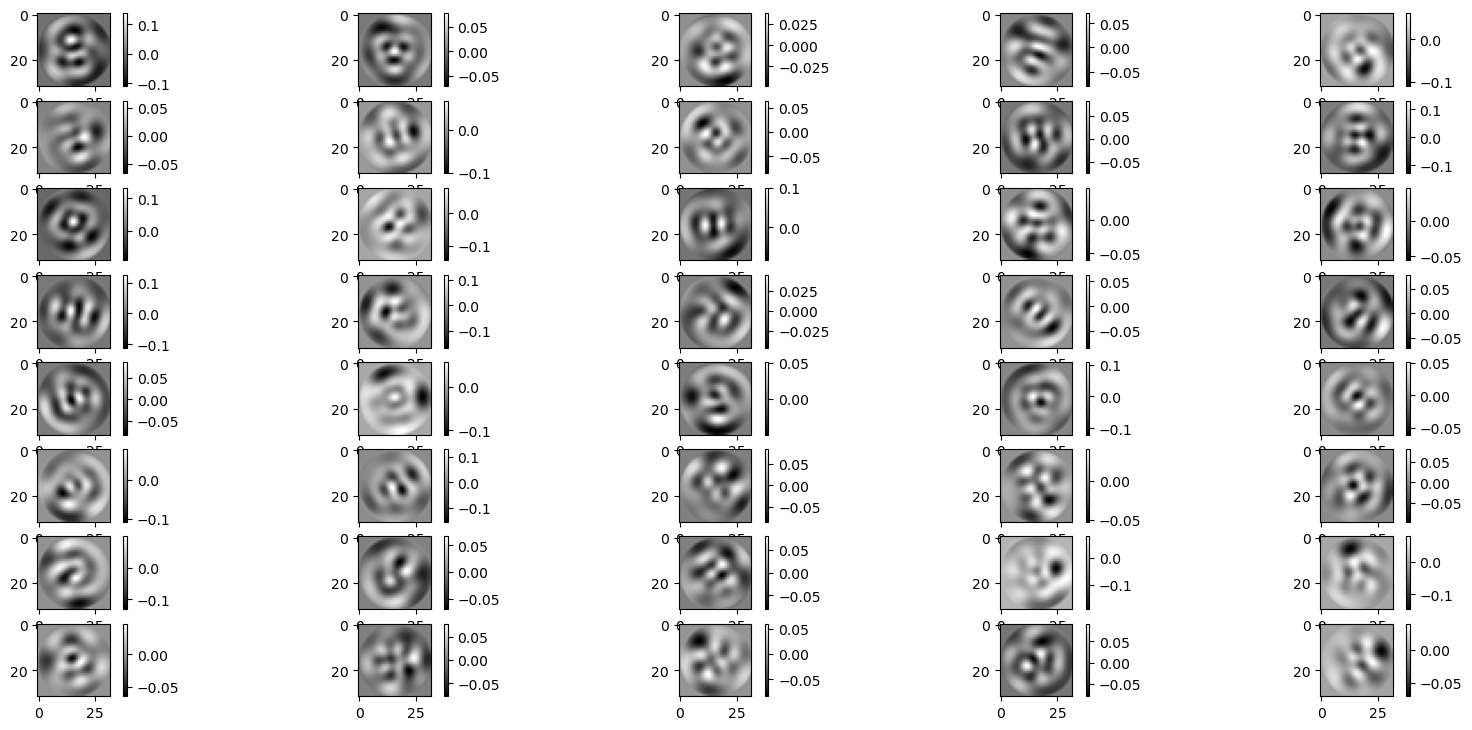

In [31]:
pre_complex = Z.data.numpy()
pre_real = basis_computer.basis.to_real(pre_complex)
after_eval = basis_computer.basis.evaluate_to_image_basis(pre_real).asnumpy()
im = Image(after_eval)
im.show()

"Denoised" Original Images


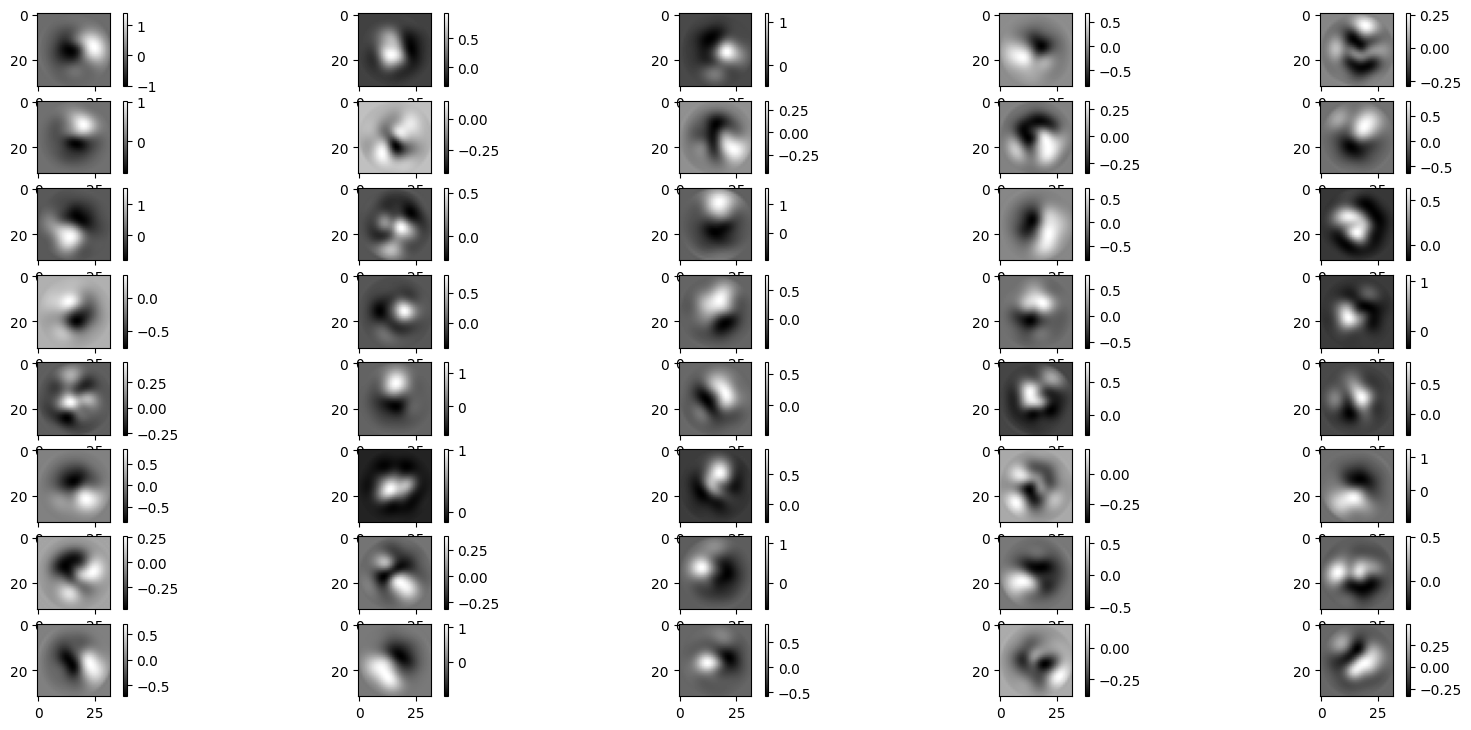

In [ ]:
after_pca_images_numpy = basis.evaluate_to_image_basis(basis.spca_coef).asnumpy()
after_pca_images = Image(after_pca_images_numpy[indices_perm])
after_pca_images.show()

Original Images


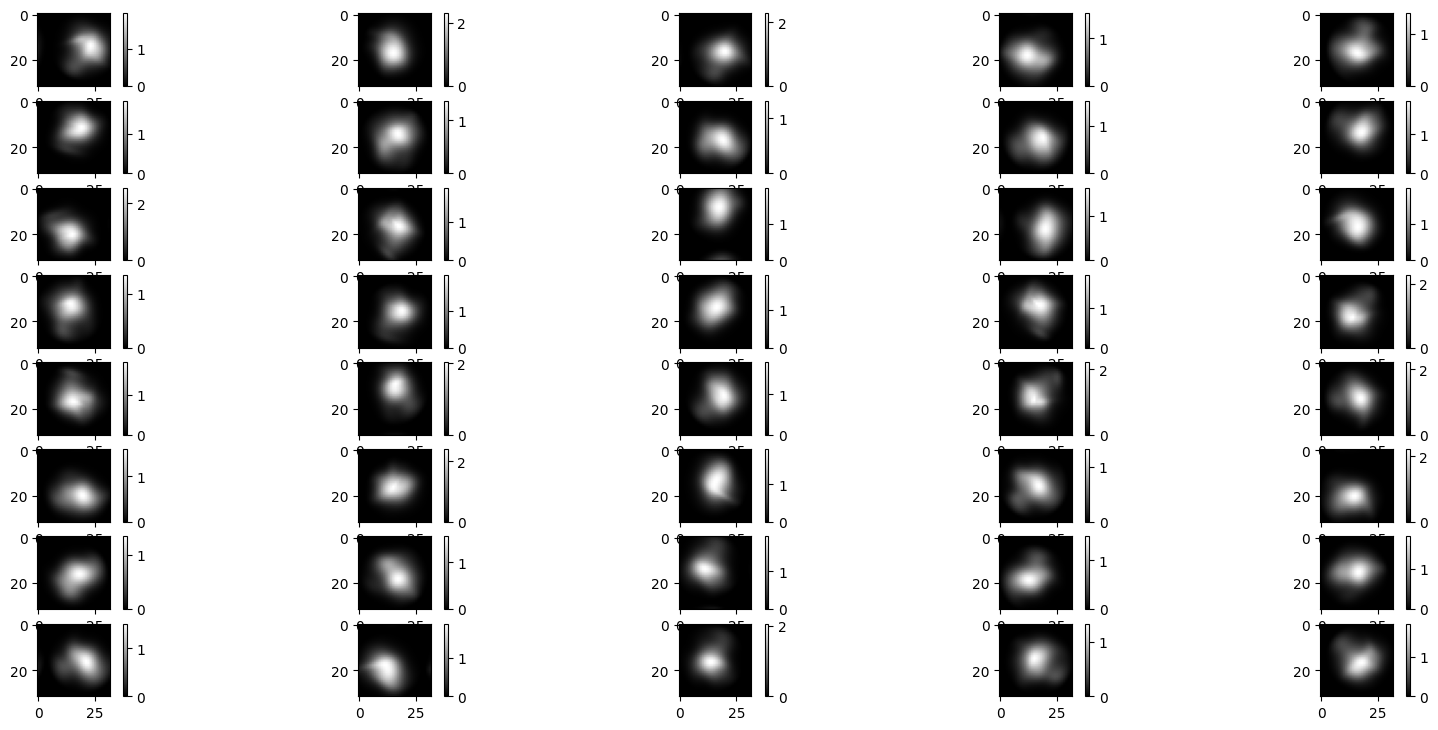

In [ ]:
src.images[indices_perm].show()

## Assessment


In [ ]:
# Assess Performance
#%load_ext line_profiler
#%lprun -f max_filter_bank_torch max_filter_bank_torch(coefs_with_refl[0],Z, fixed_ang_indices, k_max, padding = 400)

In [ ]:
srcTest, noisy_srcTest, trueNgh = gaussian_2D_mix(L = 64)

Z_images = torch.load(f='runs/Mar26_22-08-14_yousef/Z_images.pt').astype(np.float64)
assessment_dict = neighbor_assessment(src = noisy_srcTest, trueNgh = trueNgh,
    trained_templates = Z_images,
    num_select_templates = 40,
    fspca_components = 40,
    bispectrum_components = 40,
    n_nbor = 10
)


In [ ]:
srcTest = projection_src(map_path = "map_data/emd_14930.map.gz", sim = "medium")
rotation_vectors = BasisComputer.rotation_vectors(src = srcTest, withRefl = False)


In [8]:
rir_max_select_source = RIRClass2D(
        src = srcTest,
        fspca_components= 400,
        bispectrum_components=300,
        n_nbor=10,
        n_classes=100,
        selector = TopClassSelector(),
        large_pca_implementation="legacy",
        nn_implementation="sklearn",
        max_filter=True,
        max_filter_method="fft",
        max_filter_fft_padding = 400,
        max_filter_template_selection = "random_source",
        bispectrum_implementation="legacy",
        templates = 100,
        num_procs=1
    )
classes_max_select_source, reflections_max_select_source, dists_max_select_source = rir_max_select_source.classify()




In [ ]:

max_source_perc = percentage_correct_rot_vecs(classes_max_select_source, rotation_vectors, inner_cutoff = 0.95)

rir_bi = RIRClass2D(
        src = srcTest,
        fspca_components=400,
        bispectrum_components=300,
        n_nbor=10,
        n_classes=100,
        selector=TopClassSelector(),
        large_pca_implementation="legacy",
        nn_implementation="sklearn",
        max_filter= False,
        bispectrum_implementation="legacy",
        num_procs=1
    )

classes_bi, reflections_bi, dists_bi = rir_bi.classify()

bi_source_perc = percentage_correct_rot_vecs(classes_bi, rotation_vectors, inner_cutoff = 0.95)

clear_output()



In [10]:
print(bi_source_perc[0])
print(max_source_perc[0])

0.150415
0.241635


In [24]:
print(assessment_dict['Bispectrum'][0])
print(assessment_dict['Trained_Templates'][0])
print(assessment_dict['Select_Source'][0])


0.79287109375
0.848828125
0.961279296875


## Notes
